In [1]:
import torch 
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
import ncps 
from ncps.torch import LTC
from ncps.torch import CfC
from ncps.wirings import AutoNCP
import pytorch_lightning as pl
import torch.utils.data as data
import seaborn as sns
from ncps.wirings import NCP
import tensorflow as tf
sns.set()

2025-03-16 16:26:17.351705: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-03-16 16:26:17.398701: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-03-16 16:26:18.137984: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [287]:
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001

num_samples = [100_000, 20_000, 5_000]

def dpdt(point, params=params): #position

    x,y,z = point
    sig, rho, beta = params
    
    new_x = y*dt*sig + x*(1-dt*sig)
    new_y = x*dt*(rho-z) + y*(1-dt)
    new_z = x*y*dt + z*(1-dt*beta)
    return np.array([new_x, new_y, new_z])

def make_lorenz_rollout(num_samples):
    positions = []
    positions.append(initial_point)

    # your dataset
    for _ in range(num_samples):
        positions.append(dpdt(positions[-1]))

    positions = np.stack(positions)

    labels = np.sum(np.sqrt(np.square(positions[1:num_samples+1] - positions[:num_samples])), axis=1)

    return positions, labels

# Load Models

### NCPS

In [3]:
def load_ncps(num_rollouts):

    PATH = f"models/Chaos_NCPS_N{num_rollouts}.pt"
    out_features = 2
    in_features = 3
    command_neurons = 6
    
    #wiring = AutoNCP(6, out_features)  
    #wiring = NCP(inter_neurons=5, command_neurons=command_neurons, motor_neurons=out_features,
        #         sensory_fanout=5, inter_fanout=command_neurons, recurrent_command_synapses=command_neurons, motor_fanin=2)
    
    #NCPS = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh", mixed_memory=True)
    NCPS = torch.load(PATH)
    NCPS.eval()


    return NCPS

In [4]:
out_features = 3
in_features = 3

NCPS_models = []

#wiring = AutoNCP(6, out_features)  
wiring = NCP(inter_neurons=6, command_neurons=5, motor_neurons=out_features,
             sensory_fanout=4, inter_fanout=3, recurrent_command_synapses=0, motor_fanin=2)

world_model = CfC(in_features, wiring, batch_first=True, return_sequences=False, activation = "tanh") # change to cfc, what could go wrong?

for i in num_samples:
    NCPS_models.append(load_ncps(i))
    

/tmp/ipykernel_1526/2990987973.py:13: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  NCPS = torch.load(PATH)


### Res

In [5]:
def build_world_model_residual():
    xin_s = tf.keras.layers.Input((3,))

    xs = tf.keras.layers.Dense(32, activation='swish')(xin_s)
    xs = tf.keras.layers.Dense(32, activation='swish')(xs)
    xs = tf.keras.layers.Dense(3)(xs)

    xout = tf.keras.layers.Add()([xs,xin_s])
    return tf.keras.models.Model(xin_s, xout)

#build_world_model_residual().summary()

res_models = []

for i in num_samples:
    print(i)
    res = build_world_model_residual()
    res.compile(loss='mse',optimizer='adam')
    
    PATH = f"models/RESNET_state_dict_N{i}.weights.h5"
    res.load_weights(PATH)
    res_models.append(res)


2025-03-16 16:26:18.652186: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:282] failed call to cuInit: UNKNOWN ERROR (100)


100000
20000


/home/tristongrayston/.local/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:415: UserWarning: Skipping variable loading for optimizer 'adam', because it has 2 variables whereas the saved optimizer has 14 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


5000


### RNN

In [6]:
class SimpleRNN(nn.Module):
    def __init__(self, obs_space_size, action_space_size, hidden_size):
        super().__init__()
        self.l0 = nn.Sequential(
            nn.Linear(obs_space_size + action_space_size, 32),
            nn.ReLU()
        )
        
        self.rnn = nn.RNN(32, hidden_size, batch_first=True)

        self.l1 = nn.Sequential(
            nn.Linear(hidden_size, 32),
            nn.ReLU(),
            nn.Linear(32, obs_space_size),
        )
        self.hidden_size = hidden_size

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(1, x.size(0), self.hidden_size)

        out = self.l0(x)
        out, ht = self.rnn(out, h0)
        out = self.l1(out)
        out = out[:, -1, :]
        return out, ht

obs_space_size = 3
action_space_size = 0
hidden_size = 16

rnn_models = []

for i in num_samples:
    rnn = SimpleRNN(obs_space_size, action_space_size, hidden_size)
    PATH = f"models/RNN_state_dict_N{i}"
    rnn.load_state_dict(torch.load(PATH, weights_only=True))
    rnn_models.append(rnn)




# Cool Graphs

In [319]:
test_samples = num_samples[2]
in_dis_positions, _ = make_lorenz_rollout(test_samples)

print(positions.shape)

p_max = np.max(in_dis_positions)
p_min = np.min(in_dis_positions)

# Add noise
#positions = positions+np.random.randn(test_samples + 1,3) * 0.1

# Scale
in_dis_positions = in_dis_positions/p_max # (normalize to between 1 some negative number that won't be 1) 

x = []
y = []
traj_len = 1
for i in range(test_samples - traj_len):
    x.append(in_dis_positions[i:i+traj_len])
    y.append(in_dis_positions[i+traj_len:i+traj_len+1])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

t_inputs = torch.FloatTensor(data_x)
print(t_inputs.shape)


(5001, 3)
torch.Size([4999, 1, 3])


In [320]:
# now we have to make them into batches of sequence lengths
ncps = NCPS_models[0]
rnn = rnn_models[2]
res = res_models[0]

#print(rnn)

with torch.no_grad():
    rnn_1s_pred = rnn.forward(t_inputs)[0].numpy()
    ncps_1s_pred = ncps(t_inputs)[0].numpy()

res_1s_pred = np.array(res.predict(positions))
res_1s_pred.shape

157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


(5001, 3)

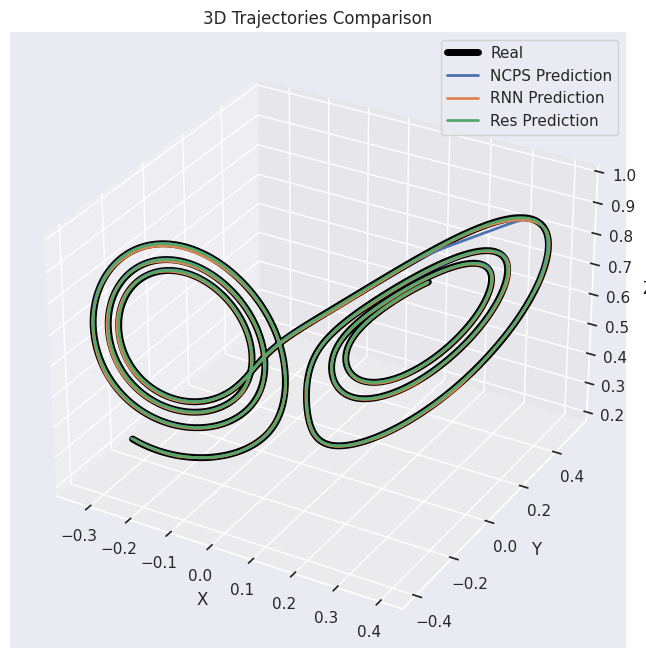

In [321]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import torch

# Example data
# t_inputs = torch.FloatTensor(inputs).unsqueeze(0)
# with torch.no_grad():
#     liq_pred = liquid(t_inputs)[0].numpy()
#     rnn_pred = rnn.forward(t_inputs)[0].numpy()
# res_pred = np.array(res.predict(inputs))

# For demonstration, assume these are each [T, 3] arrays:
# liq_pred, rnn_pred, res_pred, inputs

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the real data (inputs) as a thick line with no transparency
ax.plot(in_dis_positions[:, 0], in_dis_positions[:, 1], in_dis_positions[:, 2], linewidth=5, alpha=1.0, label='Real', color='black')

# Plot predicted trajectories with thinner lines and partial transparency
ax.plot(ncps_pred[:, 0], ncps_pred[:, 1], ncps_pred[:, 2],
         linewidth=2, alpha=1, label='NCPS Prediction')
ax.plot(rnn_pred[:, 0], rnn_pred[:, 1], rnn_pred[:, 2],
        linewidth=2, alpha=1, label='RNN Prediction')
ax.plot(res_pred[:, 0], res_pred[:, 1], res_pred[:, 2],
         linewidth=2, alpha=1, label='Res Prediction')

# Create small shaded polygons connecting each real point to the corresponding
# predicted points. This can be visually heavy if T is large, so consider
# downsampling if needed.


# Label the axes and set a title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Trajectories Comparison')

ax.legend()
plt.savefig('figures/Chaos_1_step.png')
plt.show()


In [333]:
test_samples = num_samples[2]
initial_point = np.array([10.61098536,  5.87720862, -34.48052002])
dt = 0.001
positions, _ = make_lorenz_rollout(test_samples)

print(positions.shape)

p_max = np.max(positions)
p_min = np.min(positions)

# Add noise
positions = positions+np.random.randn(test_samples + 1,3) * 0.1

# Scale
positions = positions/p_max # (normalize to between 1 some negative number that won't be 1) 

x = []
y = []
traj_len = 1
for i in range(test_samples - traj_len):
    x.append(positions[i:i+traj_len])
    y.append(positions[i+traj_len:i+traj_len+1])

#print(x, y[0])
#print(" ")
#print(x, y[1])
data_x = np.stack(x)
data_y = np.stack(y)

inputs = positions[0:-1]
t_inputs = torch.FloatTensor(data_x)
print(t_inputs.shape)
print(inputs.shape)

# now we have to make them into batches of sequence lengths

with torch.no_grad():
    ncps_ood_pred = ncps(t_inputs)[0].numpy()
    rnn_ood_pred = rnn.forward(t_inputs)[0].numpy()

res_ood_pred = np.array(res.predict(inputs))
res_ood_pred.shape

(5001, 3)
torch.Size([4999, 1, 3])
(5000, 3)
157/157 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 


(5000, 3)

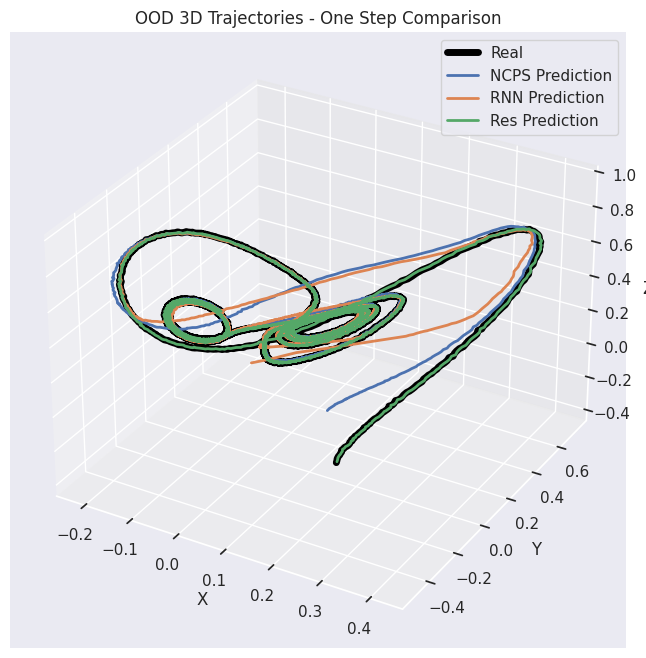

In [347]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
import numpy as np
import torch

# Example data
# t_inputs = torch.FloatTensor(inputs).unsqueeze(0)
# with torch.no_grad():
#     liq_pred = liquid(t_inputs)[0].numpy()
#     rnn_pred = rnn.forward(t_inputs)[0].numpy()
# res_pred = np.array(res.predict(inputs))

# For demonstration, assume these are each [T, 3] arrays:
# liq_pred, rnn_pred, res_pred, inputs

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plot the real data (inputs) as a thick line with no transparency
ax.plot(inputs[:, 0], inputs[:, 1], inputs[:, 2],
     linewidth=5, alpha=1.0, label='Real', color='black')

# Plot predicted trajectories with thinner lines and partial transparency
ax.plot(ncps_ood_pred[:, 0], ncps_ood_pred[:, 1], ncps_ood_pred[:, 2],
         linewidth=2, alpha=1, label='NCPS Prediction')
ax.plot(rnn_ood_pred[:, 0], rnn_ood_pred[:, 1], rnn_ood_pred[:, 2],
   linewidth=2, alpha=1, label='RNN Prediction')
ax.plot(res_ood_pred[:, 0], res_ood_pred[:, 1], res_ood_pred[:, 2],
      linewidth=2, alpha=1, label='Res Prediction')

# Create small shaded polygons connecting each real point to the corresponding
# predicted points. This can be visually heavy if T is large, so consider
# downsampling if needed.

# Label the axes and set a title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('OOD 3D Trajectories - One Step Comparison')
plt.savefig('figures/Chaos_OOD_1_step.png')
ax.legend()
plt.show()


In [335]:
# what

# NCPS Residuals
x_residuals = []
y_residuals = []
ang_vel_residuals = []

set_of_predictions = []

with torch.no_grad():
    prediction = ncps(t_inputs)[0].numpy()
print(prediction.shape)
# save predictions
#print("PRED: ", prediction)

set_of_predictions.append(prediction)

#print(y.shape)

# get residuals
#x_residuals.append(prediction[:, 0] - y[:, 0])
#y_residuals.append(prediction[:, 1] - y[:, 1])
#ang_vel_residuals.append(prediction[:, 2] - y[:, 2])

#NCPS_x_res = np.stack(x_residuals).T
#NCPS_y_res = np.stack(y_residuals).T
#NCPS_ang_res = np.stack(ang_vel_residuals).T
prediction

(4999, 3)


array([[ 0.11000186,  0.09429213, -0.15924287],
       [ 0.10956372,  0.10254199, -0.16034909],
       [ 0.10860291,  0.11167952, -0.16212995],
       ...,
       [-0.07902451, -0.03626072,  0.36811298],
       [-0.07815002, -0.03468748,  0.37004438],
       [-0.07799476, -0.03651519,  0.36711383]], dtype=float32)

Text(0.5, 1.0, 'In new notebook')

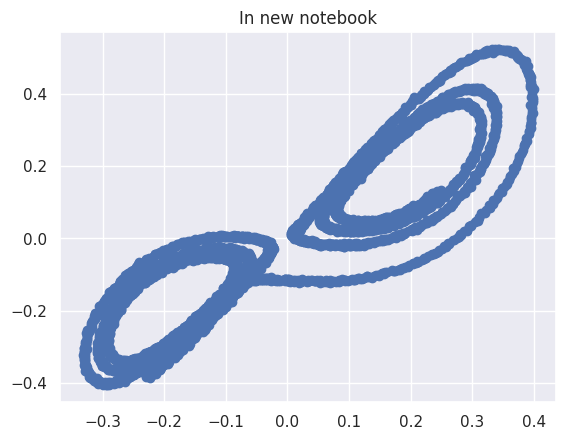

In [294]:
plt.scatter(prediction[:, 0], prediction[:, 1])
#plt.scatter(inputs[:, 0], inputs[:, 1])
#set_of_predictions.shape
plt.title("In new notebook")

# Multi-Step Rollouts

In [337]:
r_prediction = n_prediction = start = torch.FloatTensor(positions[99:100]).unsqueeze(0)
print(r_prediction)
window = inputs.shape[1]

#print(r_rolling_inputs.shape)

rnn_predictions = []
ncps_predictions = []

num_predictions = 10_000

for i in range(num_predictions):
    with torch.no_grad():
        r_prediction = rnn(r_prediction)[0].unsqueeze(0)
        n_prediction = ncps(n_prediction)[0].unsqueeze(0)


    rnn_predictions.append(r_prediction)
    ncps_predictions.append(n_prediction)
    
    #prediction = torch.FloatTensor(np.expand_dims(prediction, axis=0))
    #print(r_prediction.shape)
    #print(r_rolling_inputs.shape)

    #print(n_rolling_inputs, " ", prediction)




tensor([[[0.3687, 0.7092, 0.4692]]])


In [338]:
rnn_auto_reg_predictions = torch.stack(rnn_predictions).squeeze(1).numpy()
ncps_auto_reg_predictions = torch.stack(ncps_predictions).squeeze(1).numpy()

In [339]:
rnn_auto_reg_predictions.shape
ncps_auto_reg_predictions.shape

(10000, 1, 3)

In [340]:
#start = inputs[3:4, :]
start

tensor([[[0.3687, 0.7092, 0.4692]]])

In [341]:
res_prediction = []
#start = res(t_inputs[0, -1, :].unsqueeze(0).numpy())
start_ = np.squeeze(start.numpy(), axis=0)
print(start_.shape)
#start = start.unsqueeze(0)
res_prediction.append(np.array(res(start_)))
for i in range(num_predictions-1):
    # random action
    _state = np.array(res(res_prediction[-1]))
    #print(_state.shape)
    # pend length
    res_prediction.append(_state)

(1, 3)


In [342]:
res_auto_reg_prediction = np.stack(res_prediction)
res_auto_reg_prediction.shape

(10000, 1, 3)

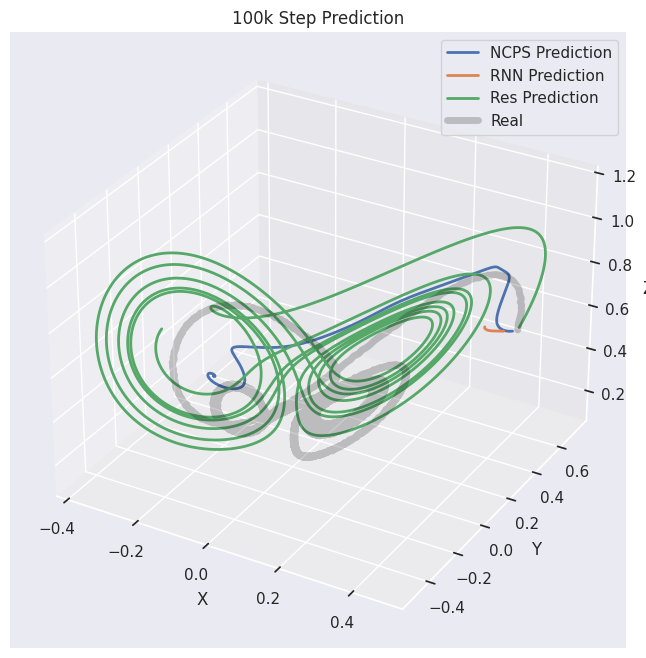

In [346]:

fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')



#Plot predicted trajectories with thinner lines and partial transparency
ax.plot(ncps_auto_reg_predictions[:, 0, 0], ncps_auto_reg_predictions[:, 0, 1], ncps_auto_reg_predictions[:, 0, 2],
        linewidth=2, alpha=1, label='NCPS Prediction')
ax.plot(rnn_auto_reg_predictions[:,0, 0], rnn_auto_reg_predictions[:, 0, 1], rnn_auto_reg_predictions[:,0, 2],
   linewidth=2, alpha=1, label='RNN Prediction')
ax.plot(res_auto_reg_prediction[:, 0, 0], res_auto_reg_prediction[:, 0, 1], res_auto_reg_prediction[:, 0, 2],
      linewidth=2, alpha=1, label='Res Prediction')

# Plot the real data (inputs) as a thick line with no transparency
ax.plot(positions[99:, 0], positions[99:, 1], positions[99:, 2],
     linewidth=5, alpha=0.2, label='Real', color='black')


# Create small shaded polygons connecting each real point to the corresponding
# predicted points. This can be visually heavy if T is large, so consider
# downsampling if needed.

# Label the axes and set a title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('100k Step Prediction')

ax.legend()
plt.savefig('figures/Chaos_100k_step.png')
plt.show()


In [ ]:
# Create a figure with 3 vertical subplots (stacked on top of each other)
fig = plt.figure(figsize=(15, 18))
ax1 = fig.add_subplot(311, projection='3d')
ax2 = fig.add_subplot(312, projection='3d')
ax3 = fig.add_subplot(313, projection='3d')

# Define a function to plot all trajectories on a given axis
def plot_all(ax):
    # Plot predicted trajectories
    ax.plot(ncps_predictions[:, 0, 0], ncps_predictions[:, 0, 1], ncps_predictions[:, 0, 2],
            linewidth=2, alpha=1, label='NCPS Prediction')
    ax.plot(rnn_predictions[:, 0, 0], rnn_predictions[:, 0, 1], rnn_predictions[:, 0, 2],
            linewidth=2, alpha=1, label='RNN Prediction')
    ax.plot(res_prediction[:, 0, 0], res_prediction[:, 0, 1], res_prediction[:, 0, 2],
            linewidth=2, alpha=1, label='Res Prediction')
    # Plot the real data
    ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
            linewidth=5, alpha=0.2, label='Real', color='black')
    
    # Label axes
    ax.set_xlabel('X')
    ax.set_ylabel('Y')
    ax.set_zlabel('Z')

# Plot all trajectories in each subplot
#for ax,  in [ax1, ax2, ax3]:
#    plot_all(ax)

# Plot the real data
ax1.plot(in_dis_positions[:, 0], in_dis_positions[:, 1], in_dis_positions[:, 2],
        linewidth=5, alpha=1, label='Real', color='black')


# Plot predicted trajectories
ax1.plot(ncps_1s_pred[:, 0], ncps_1s_pred[:, 1], ncps_1s_pred[:, 2],
        linewidth=2, alpha=1, label='NCPS Prediction')
ax1.plot(rnn_1s_pred[:, 0], rnn_1s_pred[:, 1], rnn_1s_pred[:, 2],
        linewidth=2, alpha=1, label='RNN Prediction')
ax1.plot(res_1s_pred[:, 0], res_1s_pred[:, 1], res_1s_pred[:, 2],
        linewidth=2, alpha=1, label='Res Prediction')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')

# Plot the real data
ax2.plot(in_dis_positions[:, 0], positions[:, 1], positions[:, 2],
        linewidth=5, alpha=1, label='Real', color='black')

# Plot predicted trajectories
ax2.plot(ncps_predictions[:, 0, 0], ncps_predictions[:, 1], ncps_predictions[:, 2],
        linewidth=2, alpha=1, label='NCPS Prediction')
ax2.plot(rnn_predictions[:, 0, 0], rnn_predictions[:, 0, 1], rnn_predictions[:, 0, 2],
        linewidth=2, alpha=1, label='RNN Prediction')
ax2.plot(res_prediction[:, 0, 0], res_prediction[:, 0, 1], res_prediction[:, 0, 2],
        linewidth=2, alpha=1, label='Res Prediction')


# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# Plot predicted trajectories
ax.plot(ncps_predictions[:, 0, 0], ncps_predictions[:, 0, 1], ncps_predictions[:, 0, 2],
        linewidth=2, alpha=1, label='NCPS Prediction')
ax.plot(rnn_predictions[:, 0, 0], rnn_predictions[:, 0, 1], rnn_predictions[:, 0, 2],
        linewidth=2, alpha=1, label='RNN Prediction')
ax.plot(res_prediction[:, 0, 0], res_prediction[:, 0, 1], res_prediction[:, 0, 2],
        linewidth=2, alpha=1, label='Res Prediction')
# Plot the real data
ax.plot(positions[:, 0], positions[:, 1], positions[:, 2],
        linewidth=5, alpha=1, label='Real', color='black')

# Label axes
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')


# Set different view angles for each subplot
ax1.view_init(elev=20, azim=-60)
ax2.view_init(elev=30, azim=30)
ax3.view_init(elev=40, azim=90)

# Set titles for individual subplots
ax1.set_title('View 1')
ax2.set_title('View 2')
ax3.set_title('View 3')

# Create a single legend for the whole figure (using the handles from the first subplot)
handles, labels = ax1.get_legend_handles_labels()
fig.legend(handles, labels, loc='upper right', bbox_to_anchor=(0.9, 0.95))

plt.suptitle('100k Step Prediction - Multiple Views', fontsize=16)
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig('figures/Chaos_100k_step.png')
plt.show()


# Vector Fields

In [ ]:
# Create x and y grids
x_values = np.linspace(-1, 1, 25)
y_values = np.linspace(-1, 1, 25)
z_values = np.linspace(-1, 1, 25)

x_values

torch.Size([125000, 1, 3])
torch.Size([125000, 3])


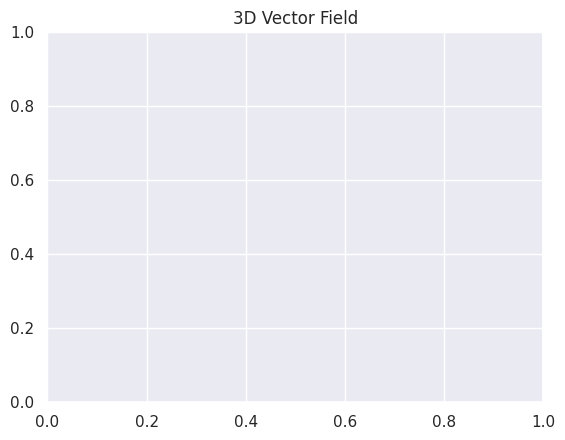

In [188]:
# --- Create x, y, and z ranges ---
x_values = np.linspace(-1, 1, 50)
y_values = np.linspace(-1, 1, 50)
z_values = np.linspace(-1, 1, 50)

# --- Create a 3D meshgrid for (x, y, z) ---
x, y, z = np.meshgrid(x_values, y_values, z_values, indexing='ij')

# Flatten and stack to create the input tensor for the model
gridspace = np.vstack([x.ravel(), y.ravel(), z.ravel()]).T
gridspace = torch.tensor(gridspace, dtype=torch.float32).unsqueeze(1)

print(gridspace.shape)

# --- Pass the grid points through your model to get the vectors ---
# Assumes 'model' is defined and returns a (N,3)-dim tensor for (Ux, Uy, Uz)
vectors = ncps(gridspace)[0]  # shape: [N, 3]

print(vectors.shape)

# Detach and reshape into the meshgrid shape
U = vectors[:, 0].detach().numpy().reshape(x.shape)
V = vectors[:, 1].detach().numpy().reshape(y.shape)
W = vectors[:, 2].detach().numpy().reshape(z.shape)

# --- Plot the 3D vector field ---
fig = plt.figure()
#ax = fig.add_subplot(111, projection='3d')
ax.quiver(x, y, z, U, V, W, length=0.2, normalize=True)
plt.title("3D Vector Field")
plt.show()

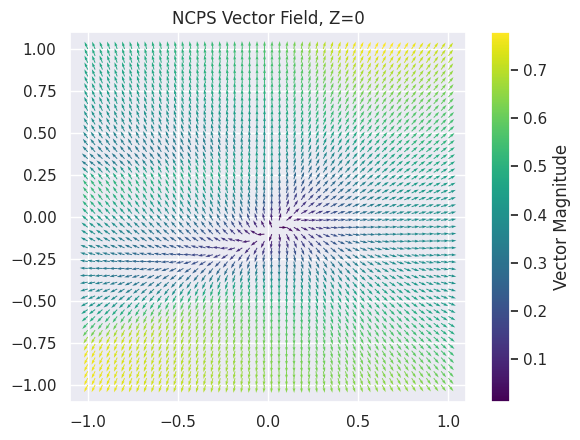

In [190]:
# Use the first slice (assuming your arrays are 3D) 
x_slice = x[:, :, 0]
y_slice = y[:, :, 0]
U_slice = U[:, :, 0]
V_slice = V[:, :, 0]

# Compute the magnitude of each vector
magnitude = np.sqrt(U_slice**2 + V_slice**2)

# Normalize the vectors (avoid division by zero)
epsilon = 1e-8
norm = magnitude + epsilon
U_norm = U_slice / norm
V_norm = V_slice / norm

# Create the quiver plot: the color of each arrow corresponds to its original magnitude.
fig, ax = plt.subplots()
q = ax.quiver(x_slice, y_slice, U_norm, V_norm, magnitude, scale=50, cmap='viridis')

# Add a colorbar to display the magnitude
cbar = fig.colorbar(q, ax=ax)
cbar.set_label('Vector Magnitude')

ax.set_title('NCPS Vector Field, Z=0')
plt.show()

# Decoherence Plots:

In [272]:
# We set an arbitrary X, an upper bound for max euclidean distance 
initial_point = np.array([10.61098536,  5.87720862, 34.48052002])
params = [10, 28, 8/3]
dt = 0.001

positions, labels = make_lorenz_rollout(100000)
positions /= np.max(positions)
labels /= np.max(positions)
X = np.max(labels) + 1/4 * np.max(labels)
X

# Various Start Positions
start_positions = np.random.randint(5, test_samples - 1000, size=100)
start_positions.shape

(100,)

In [273]:
real_trajectories = []
for i in range(1000):
    t_i = positions[start_positions + i]
    real_trajectories.append(t_i)

real_trajectories = np.stack(real_trajectories).swapaxes(0, 1)
real_trajectories.shape

(100, 1000, 3)

In [274]:
positions.shape

(100001, 3)

In [275]:
rnn_t_predictions = []
ncps_t_predictions = []
res_t_predictions = []

for i in range(3):
    
    ncps = NCPS_models[i]
    rnn = rnn_models[i]
    res = res_models[i]
    
    rnn_predictions = []
    ncps_predictions = []
    res_predictions = []
    
    num_predictions = 999

    r_prediction = n_prediction = torch.FloatTensor(real_trajectories[:, 0, :]).unsqueeze(axis=1)
    print(n_prediction.shape)
    res_prediction = real_trajectories[:, 0, :]
    

    for _ in range(num_predictions):
        with torch.no_grad():
            r_prediction = rnn(r_prediction)[0].unsqueeze(1)
            n_prediction = ncps(n_prediction)[0].unsqueeze(1)
    
        res_prediction = np.array(res(res_prediction))
    
        res_predictions.append(res_prediction)
        rnn_predictions.append(r_prediction)
        ncps_predictions.append(n_prediction)
    

    res_predictions = np.stack(res_predictions)
    rnn_predictions = torch.stack(rnn_predictions).squeeze(axis=2).swapaxes(0,1)
    ncps_predictions = torch.stack(ncps_predictions).squeeze(axis=2).swapaxes(0,1)

    print(rnn_predictions.shape)
    
    rnn_t_predictions.append(rnn_predictions)
    res_t_predictions.append(res_predictions)
    ncps_t_predictions.append(ncps_predictions)


torch.Size([100, 1, 3])
torch.Size([100, 999, 3])
torch.Size([100, 1, 3])
torch.Size([100, 999, 3])
torch.Size([100, 1, 3])
torch.Size([100, 999, 3])


In [276]:
rnn_t_predictions = torch.stack(rnn_t_predictions).numpy()
ncps_t_predictions = torch.stack(ncps_t_predictions).numpy()
res_t_predictions = np.stack(res_t_predictions).swapaxes(1, 2)

In [277]:
ncps_t_predictions.shape

(3, 100, 999, 3)

In [278]:
r = real_trajectories[:, 1:]
r.shape

(100, 999, 3)

In [279]:
real_trajectories = real_trajectories[:, 1:]
trajs = np.stack((real_trajectories, real_trajectories, real_trajectories))
trajs.shape

(3, 100, 999, 3)

In [280]:
def when_residuals_exceed_threshold(resdiuals, threshold):
    print(resdiuals.shape)
    exceeds_threshold = resdiuals > threshold # Find which points are above threshold
    indices = np.argmax(exceeds_threshold, axis=1) # Find first points above threshold
    #indices[~exceeds_threshold.any(axis=1)] = 1000    # If no point above threshold, then
                                                    # ~ = bitwise not. ~ + any = No True
    return indices




In [281]:
residual_rnns = []
rnns_indices = []
residual_res = []
res_indices = []
residual_ncps = []
ncps_indices = []
for i in range(3):
    #rnns
    rnns_res = np.sqrt(np.sum((rnn_t_predictions[i] - real_trajectories[:, :])**2, axis=-1))

    inds = when_residuals_exceed_threshold(rnns_res, X)
    rnns_indices.append(inds)
    residual_rnns.append(rnns_res)

    # residuals

    res_res = np.sqrt(np.sum((res_t_predictions[i] - real_trajectories[:, :])**2, axis=-1))

    inds = when_residuals_exceed_threshold(res_res, X)
    residual_res.append(res_res)
    res_indices.append(inds)

    # ncps
    ncps_res = np.sqrt(np.sum((ncps_t_predictions[i] - real_trajectories[:, :])**2, axis=-1))

    inds = when_residuals_exceed_threshold(ncps_res, X)
    residual_res.append(res_res)
    ncps_indices.append(inds)


(100, 999)
(100, 999)
(100, 999)
(100, 999)
(100, 999)
(100, 999)
(100, 999)
(100, 999)
(100, 999)


In [282]:
ncps_indices[0].shape

(100,)

In [283]:
np.sqrt(np.sum((res_t_predictions[0] - real_trajectories[:, :])**2, axis=-1))
#when_residuals_exceed_threshold(res_res, X)

array([[2.78194949e-05, 5.57980459e-05, 8.39230345e-05, ...,
        2.14317820e-02, 2.14367925e-02, 2.14411994e-02],
       [2.72211725e-05, 5.44418077e-05, 8.16875312e-05, ...,
        1.34376473e-02, 1.34623067e-02, 1.34879079e-02],
       [4.34748555e-05, 8.63952212e-05, 1.28771900e-04, ...,
        7.84634205e-02, 7.91120952e-02, 7.97666529e-02],
       ...,
       [3.84663504e-05, 7.69213954e-05, 1.15389097e-04, ...,
        2.20207919e-02, 2.19890381e-02, 2.19558850e-02],
       [1.25389486e-04, 2.50752160e-04, 3.76040510e-04, ...,
        2.50779807e-02, 2.50550424e-02, 2.50324745e-02],
       [5.44020281e-05, 1.08540837e-04, 1.62446168e-04, ...,
        2.62954885e-02, 2.64733084e-02, 2.66526989e-02]])

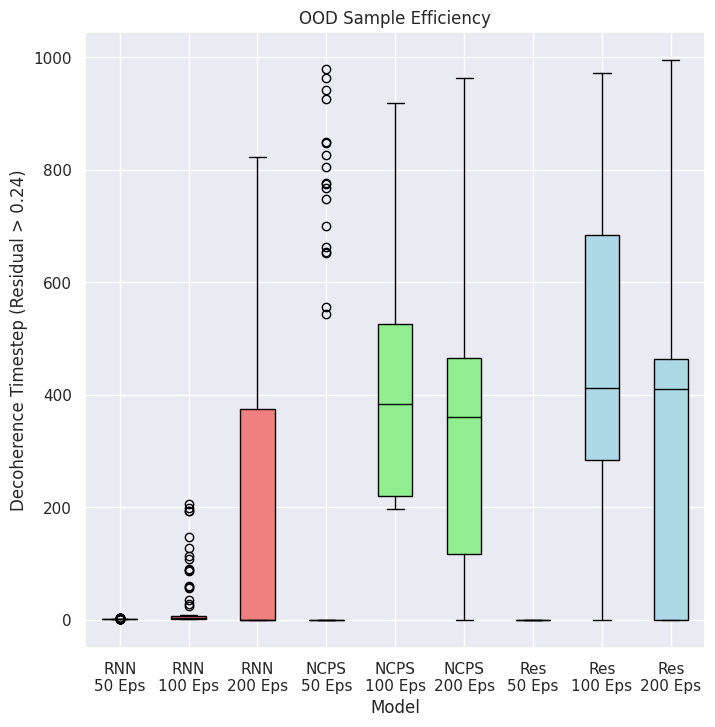

In [284]:
# Define positions for boxplots
x_positions_rnn = np.array([1, 2, 3])
x_positions_ncps = x_positions_rnn + 3
x_positions_res = x_positions_ncps + 3
all_positions = np.concatenate([x_positions_rnn, x_positions_ncps, x_positions_res])

# Create figure
plt.figure(figsize=(8, 8))

# Boxplots for RNN

#print(ood_rnn_indices.shape)

plt.boxplot(rnns_indices, positions=x_positions_rnn, widths=0.5, patch_artist=True, 
            boxprops=dict(facecolor="lightcoral"), medianprops=dict(color="black"))

# Boxplots for NCPS
plt.boxplot(ncps_indices, positions=x_positions_ncps, widths=0.5, patch_artist=True, 
             boxprops=dict(facecolor="lightgreen"), medianprops=dict(color="black"))

# Boxplots for res
plt.boxplot(res_indices, positions=x_positions_res, widths=0.5, patch_artist=True, 
             boxprops=dict(facecolor="lightblue"), medianprops=dict(color="black"))

# Labels and titles
labels = ["50 Eps", "100 Eps", "200 Eps"]
x_labels = [f"RNN\n{label}" for label in labels] + \
    [f"NCPS\n{label}" for label in labels] + \
    [f"Res\n{label}" for label in labels]

plt.xticks(all_positions, x_labels)
plt.xlabel("Model")
plt.ylabel(f"Decoherence Timestep (Residual > 0.24)")

plt.title("OOD Sample Efficiency")
plt.savefig('Box Plot ood.png')
plt.show()

